In [7]:
# Read the log file into a pandas DataFrame, split pid:tid into separate columns
import pandas as pd

def read(path):
    # Specify the file path of the log file
    # Load the log file into a pandas DataFrame with specified column names
    df = pd.read_csv(log_path, header=None, names=["pname", "pid", "tid", "syscall", "rcx", "rdx", "r8", "r9"])

    #df[['pid', 'tid']] = df['pid:tid'].str.split(':', expand=True)
    return df

log_path = 'logs/ransomwarePOC_60s.log'

df = read(log_path)


In [8]:
# Read the system call names from the csv files
# csv files are from: https://github.com/j00ru/windows-syscalls

# Client OS Windows 10 Version:
CLIENT_OS = 'Windows 10 (21H2)'

nt = pd.read_csv('nt.csv', usecols=['System call', CLIENT_OS])
nt = nt.dropna()

win32k = pd.read_csv('win32k.csv', usecols=['System call', CLIENT_OS])
win32k = win32k.dropna()
nt = pd.concat([nt, win32k], ignore_index=True)


In [9]:
# merge logs with system call names
df['syscall'] = df['syscall'].apply(lambda x: int(x, 16))
nt[CLIENT_OS] = nt[CLIENT_OS].astype(str).str.replace('0x', '', regex=False)
nt[CLIENT_OS] = nt[CLIENT_OS].apply(lambda x: int(x, 16))

df = pd.merge(df, nt, left_on='syscall', right_on=CLIENT_OS, how='left', validate='many_to_one')
df = df.drop(columns=[CLIENT_OS])
df['syscall'] = df['syscall'].apply(lambda x: hex(x)[2:])

In [19]:
# Filter for interesting process
filtered_df = df[df['pid'] == '2118']
filtered_df


,pname,pid,tid,syscall,rcx,rdx,r8,r9,System call
44,RansomwarePOC.,2118,22e8,49,18c,bbcc34a390,bbcc34a3b0,8,NtQueryVolumeInformationFile
89,RansomwarePOC.,2118,22e8,27,188,bbcc34b1a8,bbcc34b1a0,8,NtSetInformationFile
90,RansomwarePOC.,2118,22e8,8,188,0,0,0,NtWriteFile
91,RansomwarePOC.,2118,22e8,11,188,bbcc34b1d8,bbcc34b1d0,8,NtQueryInformationFile
92,RansomwarePOC.,2118,22e8,27,188,bbcc34b1d8,bbcc34b1d0,8,NtSetInformationFile
...,...,...,...,...,...,...,...,...,...
2094,RansomwarePOC.,2118,22e8,11,244,bbcc34b188,bbcc34b180,8,NtQueryInformationFile
2095,RansomwarePOC.,2118,22e8,27,244,bbcc34b188,bbcc34b180,8,NtSetInformationFile
2096,RansomwarePOC.,2118,22e8,6,244,0,0,0,NtReadFile
2097,RansomwarePOC.,2118,22e8,11,244,bbcc34b1a8,bbcc34b1a0,8,NtQueryInformationFile


<Axes: xlabel='pid'>

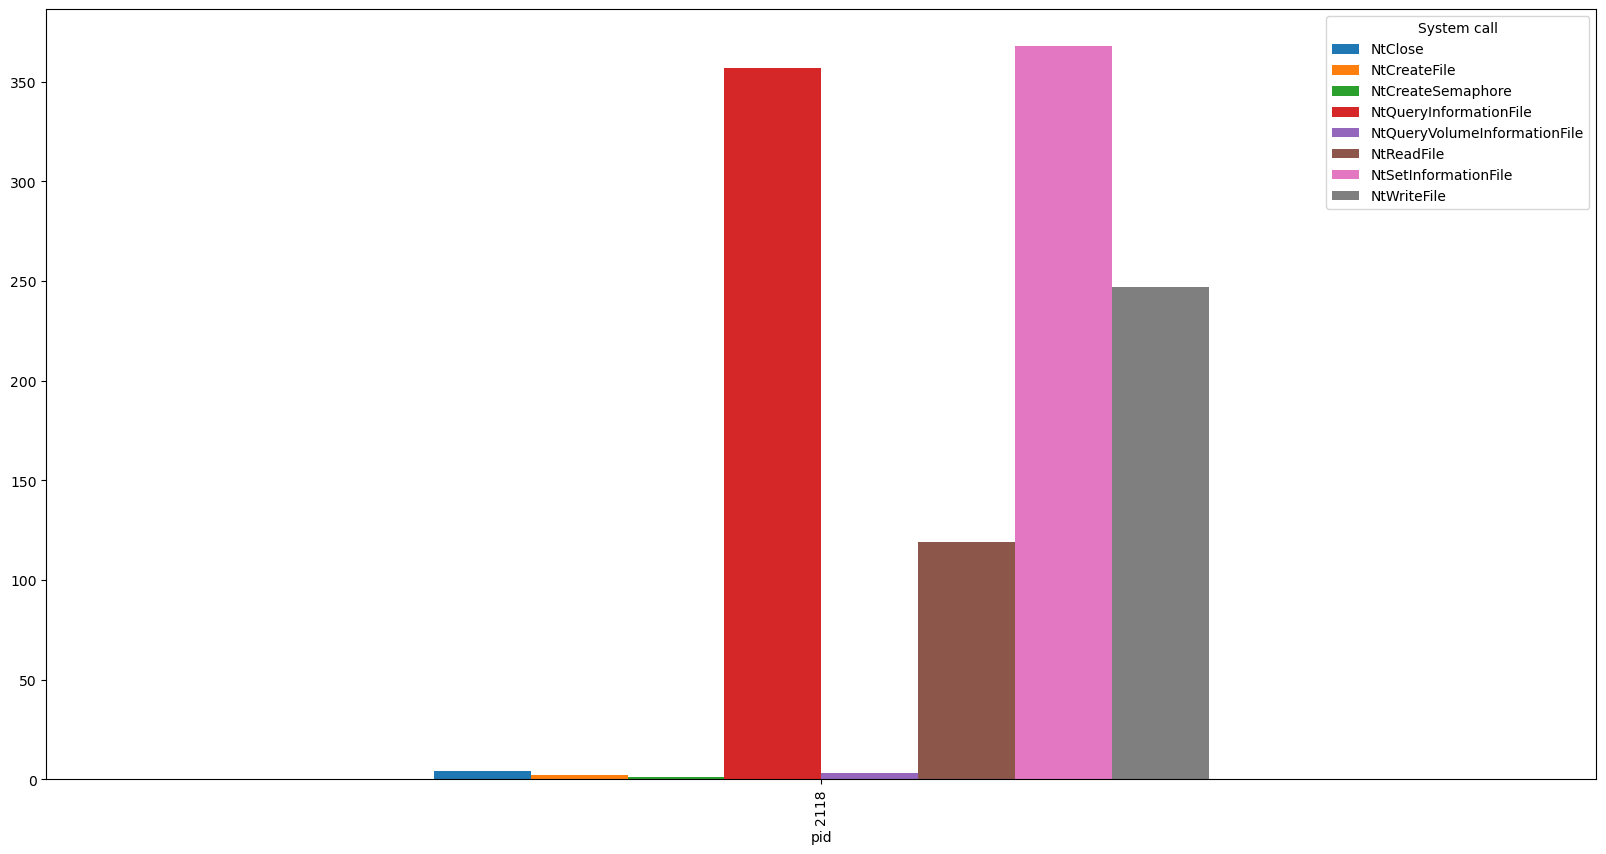

In [20]:
# Detailed view what system calls are called by RansomwarePOC
grouped_df = filtered_df.groupby(['System call', 'pid']).size().reset_index(name='count')
grouped_df.pivot_table(
        index='pid', columns='System call', values='count', fill_value=0
    ).plot(
        kind='bar', figsize=(20, 10)
    )

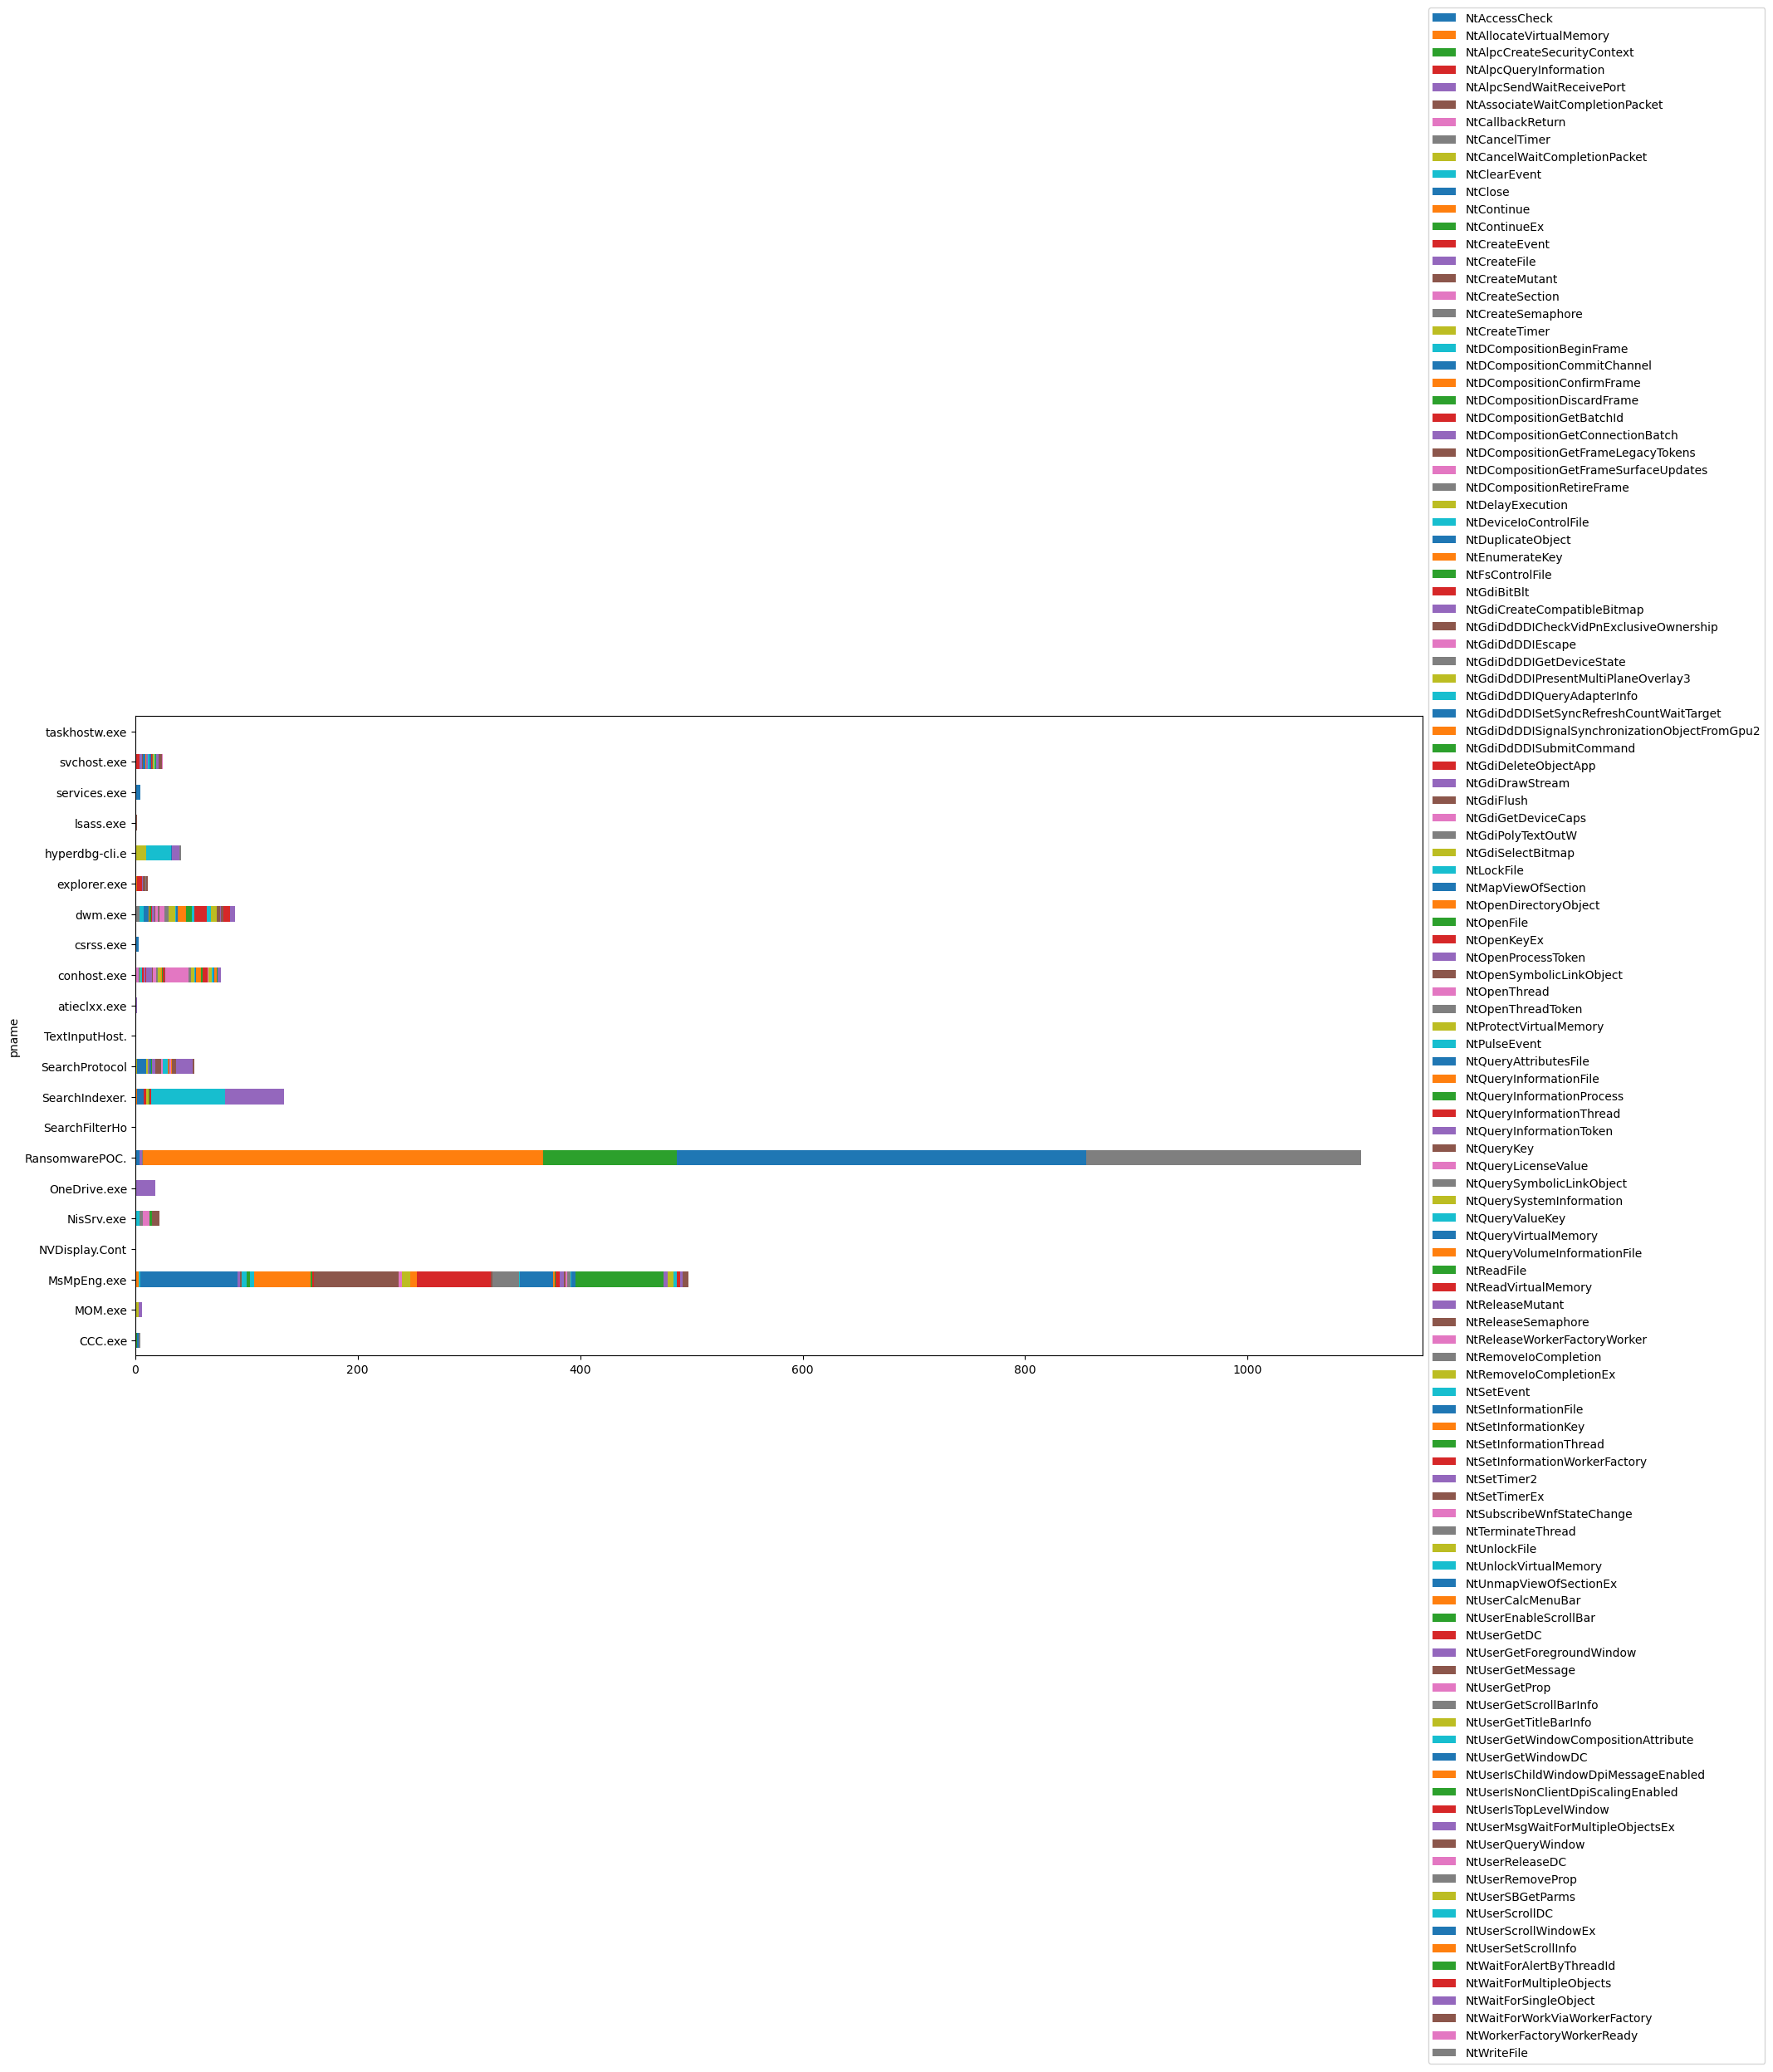

In [25]:
# Messy overview what system calls are called per process
grouped_df = df.groupby(['System call', 'pname']).size().reset_index(name='count')
grouped_df.pivot_table(
        index='pname', columns='System call', values='count', fill_value=0
    ).plot(
        kind='barh', figsize=(20, 10), stacked=True, 
    ).legend(loc='center left', bbox_to_anchor=(1, 0.5))